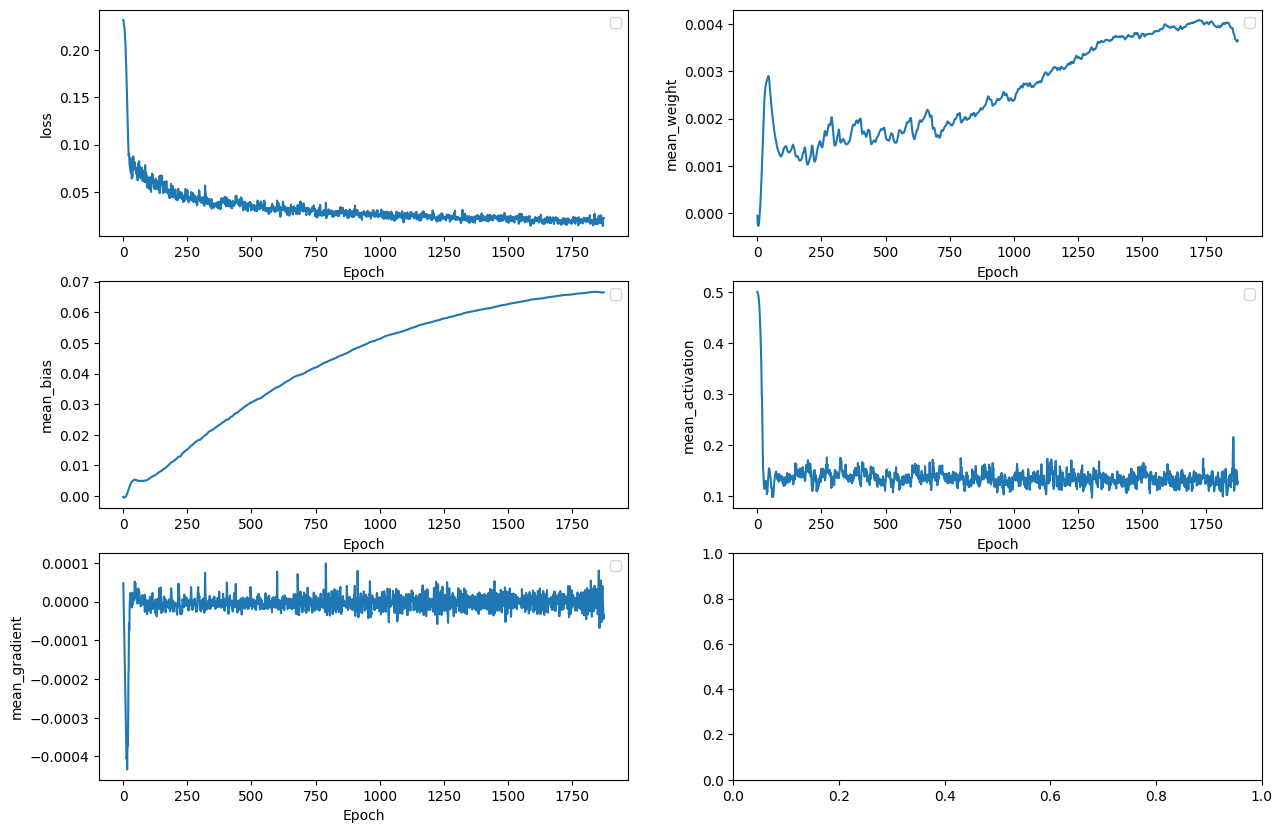

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from IPython.display import clear_output

# Load and preprocess the MNIST dataset
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    return x_train, y_train, x_test, y_test

# Define the Autoencoder architecture
class Autoencoder(models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Custom training loop
def train(autoencoder, dataset, epochs):
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam()

    metrics = {
        'loss': [],
        'mean_weight': [],
        'mean_bias': [],
        'mean_activation': [],
        'mean_gradient': []
    }

    plt.ion()
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # Prepare subplots for each metric
    lines = {key: axs[i//2, i%2].plot([], [], label=key)[0] for i, key in enumerate(metrics.keys())}
    axs = axs.flatten()

    for epoch in range(epochs):
        for step, x_batch_train in enumerate(dataset):
            with tf.GradientTape() as tape:
                reconstructed = autoencoder(x_batch_train)
                loss = loss_fn(x_batch_train, reconstructed)

            grads = tape.gradient(loss, autoencoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, autoencoder.trainable_variables))

            # Update metrics after each batch
            metrics['loss'].append(loss.numpy())
            metrics['mean_weight'].append(np.mean([np.mean(w.numpy()) for w in autoencoder.trainable_variables[::2]]))
            metrics['mean_bias'].append(np.mean([np.mean(b.numpy()) for b in autoencoder.trainable_variables[1::2]]))
            metrics['mean_activation'].append(np.mean(reconstructed.numpy()))
            metrics['mean_gradient'].append(np.mean([np.mean(g.numpy()) for g in grads]))

        # Update the plots
        for key, ax in zip(metrics.keys(), axs):
            ax.clear()
            ax.plot(metrics[key])
            ax.set_title(f'')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(key)
            ax.legend()

        plt.draw()
        plt.pause(0.001)
        clear_output(wait=True)

    plt.ioff()
    plt.show()

# Main function to execute the training
def main():
    x_train, y_train, _, _ = load_mnist_data()
    dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(32)
    autoencoder = Autoencoder()
    epochs = 10
    train(autoencoder, dataset, epochs)

if __name__ == "__main__":
    main()
